In [23]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

In [61]:
# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, KFold
from category_encoders import CatBoostEncoder

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier, Pool, cv

# Metrics
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_squared_log_error

In [25]:
from my_module import MyTransformer

Читаем данные

In [26]:
df = pd.read_csv('../data/raw/train.csv')

Проводим первичный анализ

In [27]:
df.shape

(1460, 81)

In [28]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [29]:
df['SalePrice'].describe()

count     1,460.00
mean    180,921.20
std      79,442.50
min      34,900.00
25%     129,975.00
50%     163,000.00
75%     214,000.00
max     755,000.00
Name: SalePrice, dtype: float64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

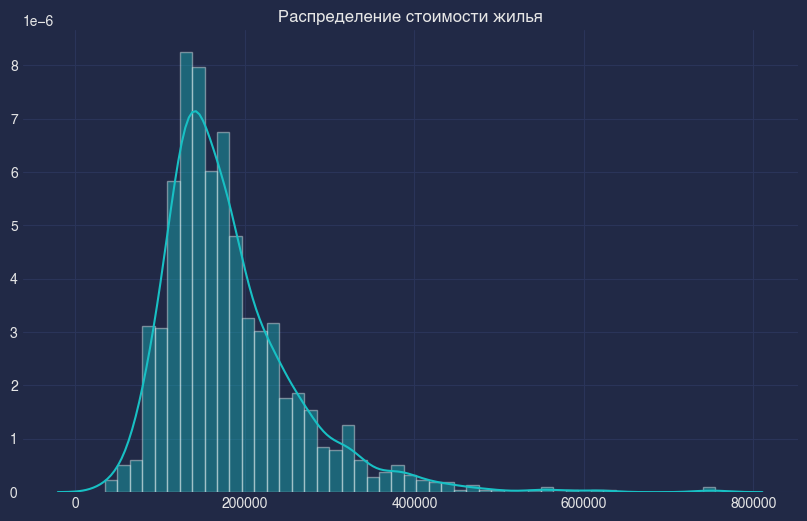

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.distplot(x=df['SalePrice'],ax=ax)

ax.set(title='Распределение стоимости жилья', xlabel='', ylabel='');

In [32]:
# делим на выборки
X, y = df.drop('SalePrice', axis=1), df['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
na_counts = X_train.isna().sum()
na_counts[na_counts > 0]

LotFrontage      217
Alley           1094
MasVnrType       683
MasVnrArea         6
BsmtQual          28
BsmtCond          28
BsmtExposure      28
BsmtFinType1      28
BsmtFinType2      28
Electrical         1
FireplaceQu      547
GarageType        64
GarageYrBlt       64
GarageFinish      64
GarageQual        64
GarageCond        64
PoolQC          1162
Fence            935
MiscFeature     1122
dtype: int64

In [34]:
# разбираемся с пропусками

columns_to_drop = ['Id','GarageYrBlt']
columns_to_fillna_with_0 = ['LotFrontage', 'MasVnrArea']
columns_to_fillna_with_no = na_counts[na_counts > 0].index.difference(columns_to_fillna_with_0)

imputer = ColumnTransformer(
    transformers=[
        ('drop', 'drop', columns_to_drop),
        ('fill_0', SimpleImputer(strategy='constant', fill_value=0), columns_to_fillna_with_0),
        ('fill_no', SimpleImputer(strategy='constant', fill_value='No'), columns_to_fillna_with_no)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

In [35]:
X = imputer.fit_transform(X)

In [36]:
# кодировка / нормировка

cat_boost_encoding_columns = X.select_dtypes(include='object').columns.tolist()
standard_scaler_columns = X.select_dtypes(exclude='object').columns.tolist()

In [37]:
scaler_and_encoder = ColumnTransformer(
    [
        ('cat_boost_encoding_columns', CatBoostEncoder(), cat_boost_encoding_columns),
        ('scaling_num_columns', StandardScaler(), standard_scaler_columns)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

In [38]:
scaler_and_encoder_2 = ColumnTransformer(
    [
        ('scale_cat_columns', StandardScaler(), cat_boost_encoding_columns)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

In [39]:
preprocessor = Pipeline(
    [
        ('custom_transformer', MyTransformer()),
        ('imputer', imputer),
        ('scaler_and_encoder', scaler_and_encoder),
        ('scaling cat_columns', scaler_and_encoder_2)
    ]
)

In [40]:
preprocessor.fit(X_train, y_train)

Pipeline(steps=[('custom_transformer', MyTransformer()),
                ('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['Id', 'GarageYrBlt']),
                                                 ('fill_0',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['LotFrontage',
                                                   'MasVnrArea']),
                                                 ('fill_no',
                                                  SimpleImputer(fill_value='No',
                                                                strategy='constant'),
                                                  Index(['Alley', 'BsmtCond', 'BsmtExposure',...
                                                   'BsmtFinType2', 'BsmtQual',
                                                   'Electrical', 'Fence',
                                                   'FireplaceQu', 'GarageCond',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageType', 'GarageYrBlt',
                                                   'MasVnrType', 'MiscFeature',
                                                   'PoolQC', 'MSZoning',
                                                   'Street', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle', ...])],
                                   verbose_feature_names_out=False))])

In [42]:
X = preprocessor.transform(X)

In [45]:
df = pd.concat([X, y], axis=1)

In [49]:
cv = KFold(n_splits=5, random_state=666, shuffle=True)
model = CatBoostRegressor(eval_metric='MAPE', verbose=False)

cb_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

In [51]:
cb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('custom_transformer', MyTransformer()),
                                 ('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop',
                                                                   'drop',
                                                                   ['Id',
                                                                    'GarageYrBlt']),
                                                                  ('fill_0',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   ['LotFrontage',
                                                                    'MasVnrArea']),
                                                                  ('fill_no',
                                                                   SimpleImputer(fill_value='No',
                                                                                 strategy='constant'),
                                                                   Index(['A...
                                                                    'GarageFinish',
                                                                    'GarageQual',
                                                                    'GarageType',
                                                                    'GarageYrBlt',
                                                                    'MasVnrType',
                                                                    'MiscFeature',
                                                                    'PoolQC',
                                                                    'MSZoning',
                                                                    'Street',
                                                                    'LotShape',
                                                                    'LandContour',
                                                                    'Utilities',
                                                                    'LotConfig',
                                                                    'LandSlope',
                                                                    'Neighborhood',
                                                                    'Condition1',
                                                                    'Condition2',
                                                                    'BldgType',
                                                                    'HouseStyle',
                                                                    'RoofStyle', ...])],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x30679a5d0>)])

In [59]:
mean_absolute_percentage_error(y_valid, cb_pipeline.predict(X_valid))

0.09180285475565787

In [62]:
mean_squared_log_error(y_valid, cb_pipeline.predict(X_valid))

0.017360574354074555